# rescue-experiment-sanity-checking
1.18.22

Taking a look at the distribution of the partitions, before and after partitioning with MNAR and MCAR schemes. 
Remember that this is a different dataset from the one we used in the DE test experiment. 

When I do a MNAR partition, the training and validation sets are right on top of each other. Would it be better to log transform the quants matrix first, then partition? Might see better separation. 

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../../../../bin/')
import util_functions
import intermediate_plots

# plotting templates
sns.set(context="talk", style="ticks") 
pal = sns.color_palette()

#### Some configs

In [2]:
# partitioning params
val_frac = 0.27
test_frac = 0.0
# setting this to 0 ensures that no peptides will be filtered out
min_present = 0     # during partitioning
q_anchor=0.2  # these three for MNAR partition 
t_std=0.2 
brnl_prob=0.3

# NMF training params
batch_size = 64

# the random number generator
rng = np.random.default_rng(seed=18)

# the random state for the partition
split_rand_state = 18

# path to the yeast calibration curve quants data
quants_path = "../../../../data/maccoss-data/yeast-cal-curves.csv"

#### Read in the quants dataset, preprocess and partition 

In [3]:
# read in the yeast calibration curves dataset
quants_orig = pd.read_csv(quants_path)

# retain the original peptide IDs
pids_orig = quants_orig["Peptide"]

# remove extraneous columns
to_remove = ["Peptide", "Protein", "numFragments"]
quants = quants_orig.drop(to_remove, axis=1)

# convert to numpy
quants = np.array(quants)

# convert zeros to NaNs
quants[quants == 0.0] = np.nan

# because this is EncyclopeDIA data we're going to convert anything <1 to NaN 
quants[quants < 1.0] = np.nan

# MCAR partition 
train, val, test = util_functions.split(
                                    quants, 
                                    val_frac=val_frac,
                                    test_frac=test_frac, 
                                    min_present=min_present,
                                    random_state=split_rand_state,
)

# # MNAR partition 
# train, val = util_functions.MNAR_partition_thresholds_matrix(
#                                     quants, 
#                                     q_anchor=q_anchor, 
#                                     t_std=t_std, 
#                                     brnl_prob=brnl_prob, 
#                                     min_pres=min_present,
#                                     rand_state=split_rand_state,
# )

#### Get the MV fractions 

In [4]:
# what is the MV fraction of the partitions? 
orig_mv_frac = np.count_nonzero(np.isnan(quants)) / quants.size
train_mv_frac = np.count_nonzero(np.isnan(train)) / train.size
val_mv_frac = np.count_nonzero(np.isnan(val)) / val.size

print("original MV frac: ", np.around(orig_mv_frac, decimals=2))
print("train MV frac: ", np.around(train_mv_frac, decimals=2))
print("val MV frac: ", np.around(val_mv_frac, decimals=2))

original MV frac:  0.29
train MV frac:  0.48
val MV frac:  0.81


#### Get the optimal number of training batches

In [5]:
# get the optimal n_batches for training and evaluation
if len(~np.isnan(train)) > 100:
    n_batches = int(np.floor(len(~np.isnan(train)) / batch_size))
    # setting the minimum n_batches to 100
    n_batches = max(n_batches, 100) 
else: 
    n_batches = 1
    
print(n_batches)

341


#### Look at the distribution of the partitions

Text(0, 0.5, 'Counts')

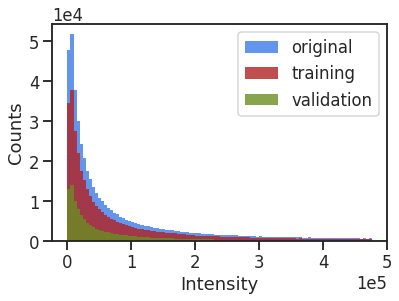

In [6]:
# flatten
quants_rav = quants.ravel()
train_rav = train.ravel()
val_rav = val.ravel()

# get the present values from the original matrix
p_quants_nans = np.isnan(quants_rav)
p_quants_present = quants_rav[~p_quants_nans]

# get present values from the training matrix
train_nans = np.isnan(train_rav)
train_present = train_rav[~train_nans]

# get present values from the validation matrix
val_nans = np.isnan(val_rav)
val_present = val_rav[~val_nans]

# get the absolute mins and maxes
quants_max = np.max(p_quants_present)
quants_min = np.min(p_quants_present)

# get the xxth quantile value
quants_qmax = np.quantile(p_quants_present, 0.75)

bwidth = np.floor((quants_qmax - quants_min) / 100) 
bins_range = np.arange(quants_min, quants_qmax, bwidth)

plt.figure()
plt.hist(p_quants_present, density=False, linewidth=0.01, bins=bins_range,
         color='cornflowerblue', edgecolor='cornflowerblue', alpha=1.0, label="original")
plt.hist(train_present, density=False, linewidth=0.01, bins=bins_range,
         color='firebrick', edgecolor='firebrick', alpha=0.8, label="training")
plt.hist(val_present, density=False, linewidth=0.01, bins=bins_range,
        color='olivedrab', edgecolor='olivedrab', alpha=0.8, label="validation")

plt.minorticks_off()

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.legend()
plt.xlabel("Intensity")
plt.ylabel("Counts")

***